In [86]:
import glob
import rasterio as rio
from rasterio import mask, features
import numpy as np
import shapely.wkt as wkt
import pandas as pd
import seaborn as sns

sub_area = wkt.loads("MULTIPOLYGON (((77462.8497438607 73703.6291953883,75345.6534984474 73935.3621177719,75366.720127755 74009.0953203485,74843.5654999498 74153.050620617,74836.5432901806 74184.6505645784,74889.2098634495 74542.7832628075,74854.0988146036 74985.182478267,74861.1210243728 75301.1819178809,74882.1876536804 75536.4259451491,74959.4319611415 75813.8032310324,76511.3403201343 75448.6483230341,76967.7839551322 75329.2707569577,76985.3394795552 74995.7157929208,77564.671785514 74005.5842154639,77462.8497438607 73703.6291953883)))")


car_dataset = rio.open('car_raster.tif', 'r', crs='EPSG:2169')
cars, transf_car =  rio.mask.mask(car_dataset, [sub_area], crop=True, indexes=1)

results = []
result_files = glob.glob('/mnt/ric_dais_nfs_maccari/gabriel/results/WONS23_new/*/luxemburg/threestep/0/r1/1/*/*/viewshed.tif')
for f in result_files:
    run_t, city, strategy, subarea, ranking, k, ratio, dens = f.split('/')[6:-1]
    with rio.open(f, 'r', crs='EPSG:2169') as dataset:
        res, transf =  rio.mask.mask(dataset, [sub_area], crop=True, indexes=1)
    cars_res = np.where(res>0, cars, 0)
    ##cars version
    if run_t == 'results_cars_bool':
        algorithm = 'pedestrian'
    else:
        algorithm = 'cars'
    results.append({'metric': 'cars',
                    'algorithm': algorithm, 
                    'dens': int(dens), 
                    'ratio': float(ratio),
                    'sum': cars_res.sum(),
                    'total': cars.sum(),
                    'coverage': cars_res.sum()/cars.sum(),
                    })
    pedestrians_res = np.where(res>0, 1, 0)
    #pedestrian version
    results.append({'metric': 'pedestrian',
                    'algorithm': algorithm,
                    'dens': int(dens), 
                    'ratio': float(ratio),
                    'sum': pedestrians_res.sum(),
                    'total': np.count_nonzero(cars),
                    'coverage': pedestrians_res.sum()/np.count_nonzero(cars)
                    })
    
res_df = pd.DataFrame(results)

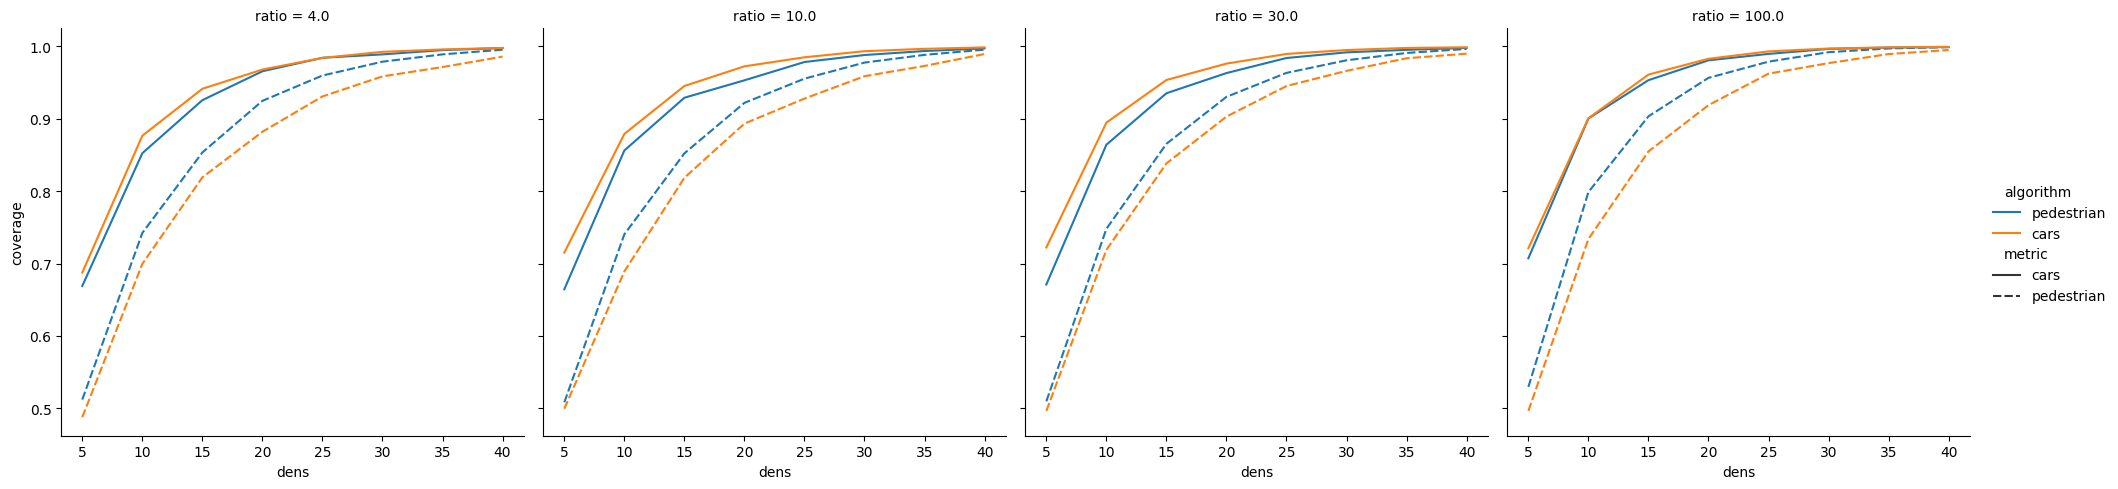

In [87]:
filt_data = res_df[(res_df.dens < 45)]
sns.relplot(data=filt_data, x='dens', y='coverage', kind='line', hue='algorithm', style='metric', col='ratio')


In [54]:
fr = open('/mnt/ric_dais_nfs_maccari/gabriel/results/WONS23/results_cars_bool/luxemburg/threestep/0/r1/1/ranking_5.txt') 
print(len(fr.read().split(',')))
fr = open('/mnt/ric_dais_nfs_maccari/gabriel/results/WONS23/results_cars/luxemburg/threestep/0/r1/1/ranking_5.txt') 
print(len(fr.read().split(',')))

217
1254
